In [467]:
### airfare_visitor lead_time 7 average & moving average 

In [656]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [679]:
from scipy.optimize import curve_fit

In [468]:
import pandas as pd
import numpy as np
from datetime import date, timedelta

import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import plot
import plotly.express as px

from tqdm import tqdm
import re

from google.cloud import bigquery

In [469]:
bqclient = bigquery.Client(project='charged-genre-350106')

In [470]:
query_visitor= """
SELECT
  A.DT,SUM(A.PCOUNT)
FROM (
  SELECT
    CONCAT(SUBSTR(CAST(DT AS string),0,4), SUBSTR(CAST(DT AS string),6,2), SUBSTR(CAST(DT AS string), 9,2)) AS DT,
    ARRIVE_PPL AS PCOUNT
  FROM
    `charged-genre-350106.kaflix.AIRLINE_PASSENGER`) AS A
GROUP BY
  A.DT
ORDER BY DT DESC
"""

In [471]:
query_airfare = """
    WITH MAIN AS (
        SELECT *
        FROM kaflix.AIRLINE_TICKET A
        WHERE 1=1
            -- AND A.DEPART = 'GMP'
            -- AND A.ARRIVE = 'CJU'
        AND A.SEARCH_DATE NOT IN ('2022-07-08', '2022-07-09', '2022-07-10',  '2022-07-12')
    )
    SELECT
        A.*
    FROM(
        SELECT
           CONCAT(CAST(FORMAT_DATE("%E4Y", CAST(LEFT(DEPART_DATE,10) as date)) AS string),
                  CAST(FORMAT_DATE("%m", CAST(LEFT(DEPART_DATE,10) as date)) AS string),
                  CAST(FORMAT_DATE("%d", CAST(LEFT(DEPART_DATE,10) as date)) AS string)) AS DEPART_DT
           , CONCAT(CAST(FORMAT_DATE("%E4Y", CAST(LEFT(SEARCH_DATE, 10) as date)) AS string),
                    CAST(FORMAT_DATE("%m", CAST(LEFT(SEARCH_DATE,10) as date)) AS string),
                    CAST(FORMAT_DATE("%d", CAST(LEFT(SEARCH_DATE,10) as date)) AS string)) AS SEARCH_DT
           , DATE_DIFF(CAST(LEFT(DEPART_DATE,10) AS date), CAST(LEFT(SEARCH_DATE,10) as date), DAY) AS LEAD_TM
        , ROUND(AVG(FARE),0) AS FARE_AVG
        FROM MAIN
        WHERE 1=1
        GROUP BY 
        DEPART_DATE, SEARCH_DATE
    ) A
    ORDER BY 
      A.DEPART_DT DESC
      , A.LEAD_TM
    """

In [472]:
query_rentcar= """
SELECT
    reserve_no
    , order_date
    , product_name
    , car_type
    , accept_date
    , accept_time
    , return_date
    , return_time
    , rental_time
    , payment_amount
    , cancel_date
FROM 
  `charged-genre-350106.bcml.bcml_rentcar`
"""

In [473]:
#today & day6beore
today = date.today()
day7before = date.today() - timedelta(7)
day7before = day7before.strftime('%Y-%m-%d')

### 과거 - 입도객 데이터

In [474]:
#입도객 데이터 로드
vst = bqclient.query(query_visitor).to_dataframe()

#컬럼명 변경
vst.columns=['date','visitor']

#datetype 변경
vst['date']=pd.to_datetime(vst['date'])

#날짜순서대로 정렬
vst=vst.sort_values(by='date')

#이동평균 컬럼
vst['visitor_7ma']=vst['visitor'].rolling(window=7).mean().round(0)

### 과거 - 항공권 데이터

In [475]:
#항공권 데이터 로드
af = bqclient.query(query_airfare).to_dataframe()

#컬럼명 변경
af.columns=['date','search_dt','lead_tm','fare_avg']

#datatype 변경
af['date']=pd.to_datetime(af['date'])
af['search_dt']=pd.to_datetime(af['search_dt'])

#lead_tm 1부터 7까지 
af=af.query("1<=lead_tm <= 7")

#날짜순서대로 변경
af=af.sort_values(by='date')

#필요한 컬럼만 선택
af=af[['date','fare_avg']]

#항공권가격 일별 평균
af=af.groupby('date').agg(['mean']).round(0).reset_index()

#멀티컬럼인덱스 flatten
af.columns = af.columns.to_flat_index().map(lambda x: x[0])

#이동평균 컬럼
af['fare_avg_7ma']=af['fare_avg'].rolling(window=7).mean().round(0)

### 과거 - 데이터 연계

In [476]:
merge_af_vst=af.merge(vst, how='left', on='date')
merge_af_vst.sort_values(by='date')

,date,fare_avg,fare_avg_7ma,visitor,visitor_7ma
0,2021-07-01,61732.0,NaN,40443.0,41150.0
1,2021-07-02,72038.0,NaN,38961.0,40286.0
2,2021-07-03,68250.0,NaN,35043.0,39142.0
3,2021-07-04,61359.0,NaN,37367.0,38109.0
4,2021-07-05,58044.0,NaN,37135.0,37492.0
...,...,...,...,...,...
466,2022-10-10,77820.0,71815.0,NaN,NaN
467,2022-10-11,77920.0,72188.0,NaN,NaN
468,2022-10-12,65965.0,73357.0,NaN,NaN
469,2022-10-13,64378.0,73675.0,NaN,NaN


In [477]:
#필요한 컬럼만 선택
merge_af_vst=merge_af_vst[['date','fare_avg_7ma','visitor_7ma']]

### 미래 - 항공권 데이터

In [478]:
#항공권 데이터 로드
af_future = bqclient.query(query_airfare).to_dataframe()

#컬럼명 변경
af_future.columns=['date','search_dt','lead_tm','fare_avg']

#datatype 변경
af_future['date']=pd.to_datetime(af_future['date'])
af_future['search_dt']=pd.to_datetime(af_future['search_dt'])

#7일전 데이터부터 
af_future=af_future[af_future['search_dt'] >= day7before].sort_values(by='date')

#필요한 컬럼만 선택
af_future=af_future[['date','fare_avg']]

#항공권가격 일별 평균
af_future=af_future.groupby('date').agg(['mean']).round(0).reset_index()

#멀티컬럼인덱스 flatten
af_future.columns = af_future.columns.to_flat_index().map(lambda x: x[0])

#이동평균 컬럼
af_future['fare_avg_7ma']=af_future['fare_avg'].rolling(window=7).mean().round(0)

#필요한 컬럼 선택
af_future=af_future[['date','fare_avg_7ma']]


### 과거 - 미래 데이터 연계

In [479]:
airfare_visitor=pd.concat([merge_af_vst,af_future], axis=0)
airfare_visitor

,date,fare_avg_7ma,visitor_7ma
0,2021-07-01,NaN,41150.0
1,2021-07-02,NaN,40286.0
2,2021-07-03,NaN,39142.0
3,2021-07-04,NaN,38109.0
4,2021-07-05,NaN,37492.0
...,...,...,...
62,2022-12-02,68463.0,NaN
63,2022-12-03,68539.0,NaN
64,2022-12-04,68844.0,NaN
65,2022-12-05,68745.0,NaN


### 제주패스 렌터카 판매가 데이터

In [480]:
jjps= bqclient.query(query_rentcar).to_dataframe()

In [481]:
# 경차 01만 선택
jjps01=jjps[jjps['car_type']=='01']

# 인수일 순서로 정렬
jjps01=jjps01.sort_values(by='accept_date')
jjps01

,reserve_no,order_date,product_name,car_type,accept_date,accept_time,return_date,return_time,rental_time,payment_amount,cancel_date
487759,2101015116899,2021-01-01 09:54:36.000,더 뉴 스파크(휘),01,20210101,1130,20210105,1500,100,44000,NaT
635794,2101012118000,2021-01-01 14:31:05.000,올 뉴 모닝(20년~)(휘),01,20210101,1630,20210104,1630,72,45900,NaT
123244,2101011117644,2021-01-01 01:04:30.000,올 뉴 모닝(20년~)(휘),01,20210101,1130,20210103,1000,47,17400,NaT
293204,2101014117664,2021-01-01 12:18:58.000,올 뉴 모닝(20년~)(휘),01,20210101,1830,20210103,1230,42,33300,NaT
796171,2101017117598,2021-01-01 16:25:38.000,올 뉴 모닝(20년~)(휘),01,20210101,1800,20210103,1800,48,30700,NaT
...,...,...,...,...,...,...,...,...,...,...,...
839915,20220911008157,2022-09-11 09:40:50.979,올 뉴 모닝(20년~)(휘),01,20230301,1030,20230305,1830,104,579600,NaT
815000,20221007009911,2022-10-07 02:28:56.274,더 뉴 스파크(21년~)(휘),01,20230301,1030,20230305,1830,104,508800,NaT
814999,20221007009925,2022-10-07 02:56:52.007,더 뉴 스파크(21년~)(휘),01,20230301,1030,20230305,1830,104,508800,NaT
814998,20221007009927,2022-10-07 02:58:57.817,더 뉴 스파크(21년~)(휘),01,20230301,1030,20230305,1830,104,508800,NaT


In [482]:
# 인수일/시간 데이트타임 형식으로 변경
jjps01['accept_date']=(jjps01['accept_date']+jjps01['accept_time']).astype('datetime64[ns]')
jjps01['return_date']=(jjps01['return_date']+jjps01['return_time']).astype('datetime64[ns]')

In [483]:
jjps01

,reserve_no,order_date,product_name,car_type,accept_date,accept_time,return_date,return_time,rental_time,payment_amount,cancel_date
487759,2101015116899,2021-01-01 09:54:36.000,더 뉴 스파크(휘),01,2021-01-01 11:30:00,1130,2021-01-05 15:00:00,1500,100,44000,NaT
635794,2101012118000,2021-01-01 14:31:05.000,올 뉴 모닝(20년~)(휘),01,2021-01-01 16:30:00,1630,2021-01-04 16:30:00,1630,72,45900,NaT
123244,2101011117644,2021-01-01 01:04:30.000,올 뉴 모닝(20년~)(휘),01,2021-01-01 11:30:00,1130,2021-01-03 10:00:00,1000,47,17400,NaT
293204,2101014117664,2021-01-01 12:18:58.000,올 뉴 모닝(20년~)(휘),01,2021-01-01 18:30:00,1830,2021-01-03 12:30:00,1230,42,33300,NaT
796171,2101017117598,2021-01-01 16:25:38.000,올 뉴 모닝(20년~)(휘),01,2021-01-01 18:00:00,1800,2021-01-03 18:00:00,1800,48,30700,NaT
...,...,...,...,...,...,...,...,...,...,...,...
839915,20220911008157,2022-09-11 09:40:50.979,올 뉴 모닝(20년~)(휘),01,2023-03-01 10:30:00,1030,2023-03-05 18:30:00,1830,104,579600,NaT
815000,20221007009911,2022-10-07 02:28:56.274,더 뉴 스파크(21년~)(휘),01,2023-03-01 10:30:00,1030,2023-03-05 18:30:00,1830,104,508800,NaT
814999,20221007009925,2022-10-07 02:56:52.007,더 뉴 스파크(21년~)(휘),01,2023-03-01 10:30:00,1030,2023-03-05 18:30:00,1830,104,508800,NaT
814998,20221007009927,2022-10-07 02:58:57.817,더 뉴 스파크(21년~)(휘),01,2023-03-01 10:30:00,1030,2023-03-05 18:30:00,1830,104,508800,NaT


In [484]:
# 리드타임 계산
jjps01['lead_time']=(jjps01['accept_date']-jjps01['order_date']).dt.days

In [485]:
# 리드타임 60일 이하만
jjps01=jjps01[jjps01['lead_time']<=60]

In [486]:
# 취소되지 않은 것만
jjps01=jjps01[jjps01['cancel_date'].isna()]

In [487]:
#분기 컬럼 추가
jjps01['quarter']=jjps01['accept_date'].dt.quarter

In [488]:
jjps01

,reserve_no,order_date,product_name,car_type,accept_date,accept_time,return_date,return_time,rental_time,payment_amount,cancel_date,lead_time,quarter
487759,2101015116899,2021-01-01 09:54:36.000,더 뉴 스파크(휘),01,2021-01-01 11:30:00,1130,2021-01-05 15:00:00,1500,100,44000,NaT,0,1
635794,2101012118000,2021-01-01 14:31:05.000,올 뉴 모닝(20년~)(휘),01,2021-01-01 16:30:00,1630,2021-01-04 16:30:00,1630,72,45900,NaT,0,1
123244,2101011117644,2021-01-01 01:04:30.000,올 뉴 모닝(20년~)(휘),01,2021-01-01 11:30:00,1130,2021-01-03 10:00:00,1000,47,17400,NaT,0,1
293204,2101014117664,2021-01-01 12:18:58.000,올 뉴 모닝(20년~)(휘),01,2021-01-01 18:30:00,1830,2021-01-03 12:30:00,1230,42,33300,NaT,0,1
796171,2101017117598,2021-01-01 16:25:38.000,올 뉴 모닝(20년~)(휘),01,2021-01-01 18:00:00,1800,2021-01-03 18:00:00,1800,48,30700,NaT,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
960717,20221001009874,2022-10-01 22:00:31.316,캐스퍼(휘),01,2022-12-01 14:30:00,1430,2022-12-03 20:00:00,2000,54,208800,NaT,60,4
527601,20221003002968,2022-10-03 21:29:05.417,더 뉴 레이(휘),01,2022-12-02 13:00:00,1300,2022-12-04 15:30:00,1530,51,145300,NaT,59,4
527602,20221003002879,2022-10-03 20:43:15.356,더 뉴 레이(휘),01,2022-12-02 13:00:00,1300,2022-12-04 15:30:00,1530,51,145300,NaT,59,4
681984,2210053209373,2022-10-05 11:44:53.000,올 뉴 모닝(17년~)(휘),01,2022-12-03 11:00:00,1100,2022-12-04 17:00:00,1700,30,48300,NaT,58,4


In [489]:
# 연도 컬럼 추가
jjps01['order_year']=pd.DatetimeIndex(jjps01['order_date']).year
jjps01['accept_year']=pd.DatetimeIndex(jjps01['accept_date']).year

In [490]:
# 시간당 렌트카 판매가 
jjps01['jjps_hour_price']=(jjps01['payment_amount']/jjps01['rental_time']).round(0)

In [491]:
jjps01

,reserve_no,order_date,product_name,car_type,accept_date,accept_time,return_date,return_time,rental_time,payment_amount,cancel_date,lead_time,quarter,order_year,accept_year,jjps_hour_price
487759,2101015116899,2021-01-01 09:54:36.000,더 뉴 스파크(휘),01,2021-01-01 11:30:00,1130,2021-01-05 15:00:00,1500,100,44000,NaT,0,1,2021,2021,440.0
635794,2101012118000,2021-01-01 14:31:05.000,올 뉴 모닝(20년~)(휘),01,2021-01-01 16:30:00,1630,2021-01-04 16:30:00,1630,72,45900,NaT,0,1,2021,2021,638.0
123244,2101011117644,2021-01-01 01:04:30.000,올 뉴 모닝(20년~)(휘),01,2021-01-01 11:30:00,1130,2021-01-03 10:00:00,1000,47,17400,NaT,0,1,2021,2021,370.0
293204,2101014117664,2021-01-01 12:18:58.000,올 뉴 모닝(20년~)(휘),01,2021-01-01 18:30:00,1830,2021-01-03 12:30:00,1230,42,33300,NaT,0,1,2021,2021,793.0
796171,2101017117598,2021-01-01 16:25:38.000,올 뉴 모닝(20년~)(휘),01,2021-01-01 18:00:00,1800,2021-01-03 18:00:00,1800,48,30700,NaT,0,1,2021,2021,640.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
960717,20221001009874,2022-10-01 22:00:31.316,캐스퍼(휘),01,2022-12-01 14:30:00,1430,2022-12-03 20:00:00,2000,54,208800,NaT,60,4,2022,2022,3867.0
527601,20221003002968,2022-10-03 21:29:05.417,더 뉴 레이(휘),01,2022-12-02 13:00:00,1300,2022-12-04 15:30:00,1530,51,145300,NaT,59,4,2022,2022,2849.0
527602,20221003002879,2022-10-03 20:43:15.356,더 뉴 레이(휘),01,2022-12-02 13:00:00,1300,2022-12-04 15:30:00,1530,51,145300,NaT,59,4,2022,2022,2849.0
681984,2210053209373,2022-10-05 11:44:53.000,올 뉴 모닝(17년~)(휘),01,2022-12-03 11:00:00,1100,2022-12-04 17:00:00,1700,30,48300,NaT,58,4,2022,2022,1610.0


In [494]:
#연도/월/일 string 타입 컬럼 추가
jjps01['date']=jjps01['accept_date'].dt.strftime("%Y-%m-%d")

In [498]:
#제주패스 시간당 가격 일평균
jjps01_price=pd.DataFrame(jjps01.groupby('date')['jjps_hour_price'].mean().round(0)).reset_index()

In [503]:
jjps01_price

,date,jjps_hour_price
0,2021-01-01,760.0
1,2021-01-02,524.0
2,2021-01-03,511.0
3,2021-01-04,463.0
4,2021-01-05,516.0
...,...,...
695,2022-11-27,1358.0
696,2022-12-01,2841.0
697,2022-12-02,2849.0
698,2022-12-03,1610.0


In [501]:
#연도/월/일 string 타입 컬럼 변경
airfare_visitor['date']=airfare_visitor['date'].dt.strftime("%Y-%m-%d")

In [502]:
airfare_visitor

,date,fare_avg_7ma,visitor_7ma
0,2021-07-01,NaN,41150.0
1,2021-07-02,NaN,40286.0
2,2021-07-03,NaN,39142.0
3,2021-07-04,NaN,38109.0
4,2021-07-05,NaN,37492.0
...,...,...,...
62,2022-12-02,68463.0,NaN
63,2022-12-03,68539.0,NaN
64,2022-12-04,68844.0,NaN
65,2022-12-05,68745.0,NaN


In [505]:
# 항공권/입도객/
af_vst_prc=airfare_visitor.merge(jjps01_price, how='left', on='date')

In [506]:
af_vst_prc

,date,fare_avg_7ma,visitor_7ma,jjps_hour_price
0,2021-07-01,NaN,41150.0,3079.0
1,2021-07-02,NaN,40286.0,3095.0
2,2021-07-03,NaN,39142.0,3132.0
3,2021-07-04,NaN,38109.0,2812.0
4,2021-07-05,NaN,37492.0,2651.0
...,...,...,...,...
533,2022-12-02,68463.0,NaN,2849.0
534,2022-12-03,68539.0,NaN,1610.0
535,2022-12-04,68844.0,NaN,2484.0
536,2022-12-05,68745.0,NaN,NaN


In [507]:
af_vst_prc['jjps_hour_price_7ma']=af_vst_prc['jjps_hour_price'].rolling(window=7).mean().round(0)

In [508]:
af_vst_prc.tail(60)

,date,fare_avg_7ma,visitor_7ma,jjps_hour_price,jjps_hour_price_7ma
478,2022-10-08,71452.0,NaN,2910.0,2139.0
479,2022-10-09,71377.0,NaN,2518.0,2148.0
480,2022-10-10,71526.0,NaN,1862.0,2184.0
481,2022-10-11,72068.0,NaN,1550.0,2222.0
482,2022-10-12,72955.0,NaN,1689.0,2258.0
483,2022-10-13,73343.0,NaN,1925.0,2193.0
484,2022-10-14,76224.0,NaN,2050.0,2072.0
485,2022-10-15,77899.0,NaN,2002.0,1942.0
486,2022-10-16,79070.0,NaN,1960.0,1863.0
487,2022-10-17,78942.0,NaN,1621.0,1828.0


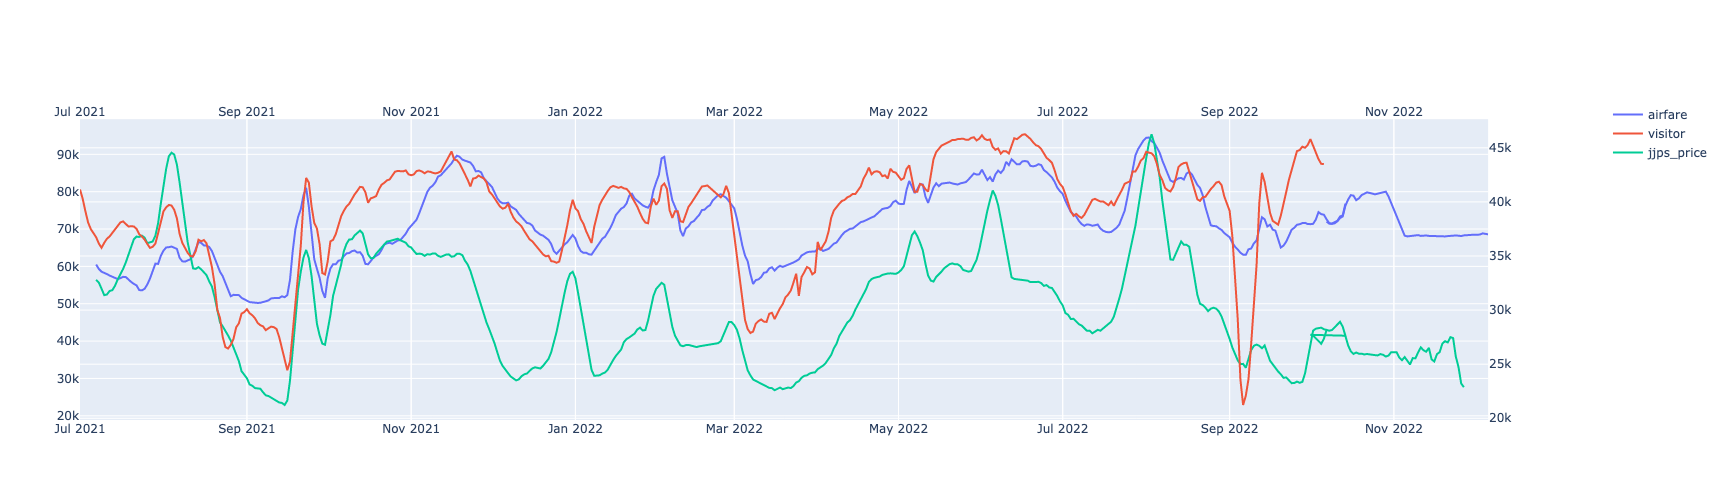

In [509]:
fig=make_subplots(
        specs=[[{"secondary_y": True}]])   

fig.update_layout(xaxis2= {'anchor': 'y', 'overlaying': 'x', 'side': 'top'},
                  yaxis_domain=[0, 0.94]);

fig.add_trace(
    go.Scatter(x=af_vst_prc['date'], y=af_vst_prc['fare_avg_7ma'], name="airfare"),
    secondary_y=False
)

fig.add_trace(
    go.Scatter(x=af_vst_prc['date'], y=af_vst_prc['visitor_7ma'], name="visitor"),
    secondary_y=True
)

fig.add_trace(
    go.Scatter(x=af_vst_prc['date'], y=af_vst_prc['jjps_hour_price_7ma']*20, name="jjps_price"),
    secondary_y=False
)

fig.data[1].update(xaxis='x2')
fig.update_layout(width=1500, height=500)


fig.show()

# fig.show()
#plot(fig, filename='airfare_visitor.html')

In [510]:
#특정 이벤트가 있는 연휴인 경우, 설/추석연휴 다음날부터 주말까지, 징검다리 등에서 가격이 급격하게 상승 그외 구간은 전반적으로 입도객,항공권 가격 트렌드를 따라가는 경향이 있음

### erp(리본) 렌터카 판매가 데이터

In [511]:
#경차 01 데이터 로드
type_01=pd.read_csv('type_01.csv', encoding='euc-kr')

In [513]:
# 필요한 데이터만 선택
type_01=type_01[['model_name','car_type']]

In [514]:
type_01

,model_name,car_type
0,모닝,1
1,더뉴 스파크,1
2,더뉴모닝휘,1
3,올 뉴 모닝0,1
4,넥스트스파크,1
5,1821 올뉴 모닝,1
6,올뉴모닝 19년,1
7,모닝 휘발유 2017,1
8,올뉴모닝럭셔리,1
9,캐스퍼휘4인승,1


In [515]:
query_erp= """
SELECT
    erp_reserve_no
    , jejupass_reserve_no
    , corp_code
    , compnay_name as company_name
    , model_name
    , reserve_date
    , accept_date
    , return_date
    , cancel_date
    , deposit
FROM 
  `charged-genre-350106.bcml.bcml_erp`
"""

In [516]:
# erp 데이터 로드
erp_o = bqclient.query(query_erp).to_dataframe()

In [517]:
# 중복 데이터 제거
erp_o_np=erp_o.drop_duplicates(['model_name'])

# 리인덱싱(중간에 빠진 인덱스넘버 제거)
erp_o_np=erp_o_np.reset_index()

In [518]:
erp_o_np

,index,erp_reserve_no,jejupass_reserve_no,corp_code,company_name,model_name,reserve_date,accept_date,return_date,cancel_date,deposit
0,0,22051909369,ticket_6285b8c1ed58a,AUTOZEN,레인보우모빌리티,K3,20220519122617,202205300800,202206021930,NaT,216000
1,197,22012996331,S10005504,RMGANGSEO,렌트카매니아강서지점,K5,20220129111233,202201291500,202201301500,NaT,96400
2,205,21111572792,S10004943,SERYUN,(주)세륜,k3,20211115113939,202111201200,202111211700,2021-11-15 11:40:05,117300
3,206,21041587729,None,AUTOZEN,레인보우모빌리티,CT5,20210415182401,202104151823,202104161200,2021-04-15 18:35:51,0
4,207,22061047017,1646390,METRO,메트로렌트카,NK3,20220610113532,202207030830,202207071000,2022-06-16 13:24:08,258560
...,...,...,...,...,...,...,...,...,...,...,...
1195,929444,22090884027,G100002733,GWANGJU,㈜일구구사투어렌트카 광주지점,쏘나타 뉴 라이즈 L 2018 │ 24호2412,20220908022420,202210011100,202210021600,NaT,95000
1196,929448,22092202764,G100002805,GWANGJU,㈜일구구사투어렌트카 광주지점,쏘렌토 더 마스터 D 2019 │105허1117,20220922160725,202210011000,202210032000,NaT,330000
1197,929449,22100623410,G100002887,GWANGJU,㈜일구구사투어렌트카 광주지점,아반떼 AD 스포츠 G 2018 │ 147호1005,20221006000657,202210061500,202210101500,NaT,200000
1198,930053,21080289816,None,JREMCAR,제이렘카플릭스,2020 The K9 3800 플래티넘 II AT 휘발유 2020,20210802125806,202108021300,202108291820,NaT,0


In [520]:
# 텍스트 전처리 컬럼 만들고
erp_o_np['model_name_re']=''

In [521]:
# 특수문자 및 괄호 및 괄호 안 문자 제거
for i in tqdm(range(len(erp_o_np))):
    erp_o_np['model_name_re'][i]=re.sub('[-=+,#/\?:^.@*\"※~ㆍ!』‘|\(\)\[\]`\'…》\”\“\’·]','',erp_o_np['model_name'][i])
    erp_o_np['model_name_re'][i]=re.sub('\(.*\)|\s-\s.*','',erp_o_np['model_name'][i])


  0%|          | 0/1200 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|██████████| 1200/1200 [00:00<00:00, 1713.58it/s]


In [522]:
erp_o_np

,index,erp_reserve_no,jejupass_reserve_no,corp_code,company_name,model_name,reserve_date,accept_date,return_date,cancel_date,deposit,model_name_re
0,0,22051909369,ticket_6285b8c1ed58a,AUTOZEN,레인보우모빌리티,K3,20220519122617,202205300800,202206021930,NaT,216000,K3
1,197,22012996331,S10005504,RMGANGSEO,렌트카매니아강서지점,K5,20220129111233,202201291500,202201301500,NaT,96400,K5
2,205,21111572792,S10004943,SERYUN,(주)세륜,k3,20211115113939,202111201200,202111211700,2021-11-15 11:40:05,117300,k3
3,206,21041587729,None,AUTOZEN,레인보우모빌리티,CT5,20210415182401,202104151823,202104161200,2021-04-15 18:35:51,0,CT5
4,207,22061047017,1646390,METRO,메트로렌트카,NK3,20220610113532,202207030830,202207071000,2022-06-16 13:24:08,258560,NK3
...,...,...,...,...,...,...,...,...,...,...,...,...
1195,929444,22090884027,G100002733,GWANGJU,㈜일구구사투어렌트카 광주지점,쏘나타 뉴 라이즈 L 2018 │ 24호2412,20220908022420,202210011100,202210021600,NaT,95000,쏘나타 뉴 라이즈 L 2018 │ 24호2412
1196,929448,22092202764,G100002805,GWANGJU,㈜일구구사투어렌트카 광주지점,쏘렌토 더 마스터 D 2019 │105허1117,20220922160725,202210011000,202210032000,NaT,330000,쏘렌토 더 마스터 D 2019 │105허1117
1197,929449,22100623410,G100002887,GWANGJU,㈜일구구사투어렌트카 광주지점,아반떼 AD 스포츠 G 2018 │ 147호1005,20221006000657,202210061500,202210101500,NaT,200000,아반떼 AD 스포츠 G 2018 │ 147호1005
1198,930053,21080289816,None,JREMCAR,제이렘카플릭스,2020 The K9 3800 플래티넘 II AT 휘발유 2020,20210802125806,202108021300,202108291820,NaT,0,2020 The K9 3800 플래티넘 II AT 휘발유 2020


In [523]:
# 필요한(모델명, 전처리된 모델명) 컬럼 선택
erp_o_np=erp_o_np[['model_name', 'model_name_re']]
# 소문자를 대문자로 변환
erp_o_np['model_name_re']=erp_o_np['model_name_re'].str.upper()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [524]:
erp_o_np

,model_name,model_name_re
0,K3,K3
1,K5,K5
2,k3,K3
3,CT5,CT5
4,NK3,NK3
...,...,...
1195,쏘나타 뉴 라이즈 L 2018 │ 24호2412,쏘나타 뉴 라이즈 L 2018 │ 24호2412
1196,쏘렌토 더 마스터 D 2019 │105허1117,쏘렌토 더 마스터 D 2019 │105허1117
1197,아반떼 AD 스포츠 G 2018 │ 147호1005,아반떼 AD 스포츠 G 2018 │ 147호1005
1198,2020 The K9 3800 플래티넘 II AT 휘발유 2020,2020 THE K9 3800 플래티넘 II AT 휘발유 2020


In [292]:
#erp.to_csv('erp_re.csv', encoding='euc-kr')

In [525]:
# 차모델명 일원화(필요한 것만)
for i in tqdm(range(len(erp_o_np))):
    if '소나타' in erp_o_np['model_name_re'][i]:
        erp_o_np['model_name_re'][i]='쏘나타'
    elif '아반테' in erp_o_np['model_name_re'][i]:
        erp_o_np['model_name_re'][i]='아반떼'
    elif '그랜져' in erp_o_np['model_name_re'][i]:
        erp_o_np['model_name_re'][i]='그랜저'
    elif 'PEUGEOT' in erp_o_np['model_name_re'][i]:
        erp_o_np['model_name_re'][i]='푸조'
    elif '산타페' in erp_o_np['model_name_re'][i]:
        erp_o_np['model_name_re'][i]='싼타페'
    elif '시트로앵' in erp_o_np['model_name_re'][i]:
        erp_o_np['model_name_re'][i]='시트로엥'
    elif 'RAY' in erp_o_np['model_name_re'][i]:
        erp_o_np['model_name_re'][i]='레이'
    elif '테슬라' in erp_o_np['model_name_re'][i]:
        erp_o_np['model_name_re'][i]='테슬라모델3'
    elif '뉴라이즈' in erp_o_np['model_name_re'][i]:
        erp_o_np['model_name_re'][i]='쏘나타'
    elif '아이오니' in erp_o_np['model_name_re'][i]:
        erp_o_np['model_name_re'][i]='아이오닉'
    elif '올뉴카' in erp_o_np['model_name_re'][i]:
        erp_o_np['model_name_re'][i]='카니발'
    elif 'PRIUS' in erp_o_np['model_name_re'][i]:
        erp_o_np['model_name_re'][i]='프리우스'
    elif '펠리세이드' in erp_o_np['model_name_re'][i]:
        erp_o_np['model_name_re'][i]='팰리세이드'
    elif 'AD' in erp_o_np['model_name_re'][i]:
        erp_o_np['model_name_re'][i]='아반떼'
    elif 'CN7' in erp_o_np['model_name_re'][i]:
        erp_o_np['model_name_re'][i]='아반떼'
    elif 'LF' in erp_o_np['model_name_re'][i]:
        erp_o_np['model_name_re'][i]='쏘나타'
    elif 'DL3' in erp_o_np['model_name_re'][i]:
        erp_o_np['model_name_re'][i]='K5'
    elif 'DN8' in erp_o_np['model_name_re'][i]:
        erp_o_np['model_name_re'][i]='쏘나타'
    # elif '2008' in erp_o_np['model_name_re'][i]:
    #     erp_o_np['model_name_re'][i]='푸조 2008'
    # elif '5008' in erp_o_np['model_name_re'][i]:
    #     erp_o_np['model_name_re'][i]='푸조 5008'
    # elif '3008' in erp_o_np['model_name_re'][i]:
    #     erp_o_np['model_name_re'][i]='푸조 3008'   
    elif 'rise' in erp_o_np['model_name_re'][i]:
        erp_o_np['model_name_re'][i]='쏘나타'
    elif '아이써티' in erp_o_np['model_name_re'][i]:
        erp_o_np['model_name_re'][i]='I30'

  0%|          | 0/1200 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: Set

In [526]:
# 컬럼명 수정
erp_o_np.columns=['model_name','model_name_final']

In [527]:
erp_o_np

,model_name,model_name_final
0,K3,K3
1,K5,K5
2,k3,K3
3,CT5,CT5
4,NK3,NK3
...,...,...
1195,쏘나타 뉴 라이즈 L 2018 │ 24호2412,쏘나타 뉴 라이즈 L 2018 │ 24호2412
1196,쏘렌토 더 마스터 D 2019 │105허1117,쏘렌토 더 마스터 D 2019 │105허1117
1197,아반떼 AD 스포츠 G 2018 │ 147호1005,아반떼
1198,2020 The K9 3800 플래티넘 II AT 휘발유 2020,2020 THE K9 3800 플래티넘 II AT 휘발유 2020


In [528]:
# 텍스트 전처리된 차모델명 컬럼 조인
erp_merge=erp_o.merge(erp_o_np, how='left', on='model_name')

In [529]:
erp_merge

,erp_reserve_no,jejupass_reserve_no,corp_code,company_name,model_name,reserve_date,accept_date,return_date,cancel_date,deposit,model_name_final
0,22051909369,ticket_6285b8c1ed58a,AUTOZEN,레인보우모빌리티,K3,20220519122617,202205300800,202206021930,NaT,216000,K3
1,22051602300,ticket_6281a0d66e115,AUTOZEN,레인보우모빌리티,K3,20220516095449,202206070930,202206101200,NaT,182100,K3
2,22051501889,1626282,AUTOZEN,레인보우모빌리티,K3,20220515224225,202205310830,202206021730,2022-05-18 07:19:43,157800,K3
3,22051501240,2974-2973,AUTOZEN,레인보우모빌리티,K3,20220515160201,202206080830,202206111500,NaT,200700,K3
4,22051400139,1625490,AUTOZEN,레인보우모빌리티,K3,20220514224147,202206081400,202206101000,2022-05-14 22:57:04,117200,K3
...,...,...,...,...,...,...,...,...,...,...,...
932281,21022586918,262386_0,ANGEL,제주엔젤렌트카,더뉴 그랜드스타렉스 리무진 9인승 19년(경유),20210225121622,202102271000,202103011700,2021-02-25 15:02:34,351000,더뉴 그랜드스타렉스 리무진 9인승 19년
932282,21022586881,262217_0,ANGEL,제주엔젤렌트카,더뉴 그랜드스타렉스 리무진 9인승 19년(경유),20210225112834,202102271200,202103011800,NaT,332800,더뉴 그랜드스타렉스 리무진 9인승 19년
932283,21022485554,230992-261795,ANGEL,제주엔젤렌트카,더뉴 그랜드스타렉스 리무진 9인승 19년(경유),20210224141835,202105191330,202105231600,NaT,711400,더뉴 그랜드스타렉스 리무진 9인승 19년
932284,21021467901,225946-256138,ANGEL,제주엔젤렌트카,더뉴 그랜드스타렉스 리무진 9인승 19년(경유),20210214114113,202102231230,202102261200,2021-02-18 11:25:55,265200,더뉴 그랜드스타렉스 리무진 9인승 19년


In [221]:
#erp.to_csv('erp_re2.csv', encoding='euc-kr')

In [533]:
type_01

,model_name_final,car_type
0,모닝,1
1,더뉴 스파크,1
2,더뉴모닝휘,1
3,올 뉴 모닝0,1
4,넥스트스파크,1
5,1821 올뉴 모닝,1
6,올뉴모닝 19년,1
7,모닝 휘발유 2017,1
8,올뉴모닝럭셔리,1
9,캐스퍼휘4인승,1


In [530]:
#경차 모델명/ 차종 테이블 컬럼명 수정
type_01.columns=['model_name_final','car_type']

In [531]:
#경차 차종 테이블과 erp 테이블 조인
erp_type01=erp_merge.merge(type_01, how='left', on='model_name_final')

In [532]:
erp_type01

,erp_reserve_no,jejupass_reserve_no,corp_code,company_name,model_name,reserve_date,accept_date,return_date,cancel_date,deposit,model_name_final,car_type
0,22051909369,ticket_6285b8c1ed58a,AUTOZEN,레인보우모빌리티,K3,20220519122617,202205300800,202206021930,NaT,216000,K3,NaN
1,22051602300,ticket_6281a0d66e115,AUTOZEN,레인보우모빌리티,K3,20220516095449,202206070930,202206101200,NaT,182100,K3,NaN
2,22051501889,1626282,AUTOZEN,레인보우모빌리티,K3,20220515224225,202205310830,202206021730,2022-05-18 07:19:43,157800,K3,NaN
3,22051501240,2974-2973,AUTOZEN,레인보우모빌리티,K3,20220515160201,202206080830,202206111500,NaT,200700,K3,NaN
4,22051400139,1625490,AUTOZEN,레인보우모빌리티,K3,20220514224147,202206081400,202206101000,2022-05-14 22:57:04,117200,K3,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
932624,21022586918,262386_0,ANGEL,제주엔젤렌트카,더뉴 그랜드스타렉스 리무진 9인승 19년(경유),20210225121622,202102271000,202103011700,2021-02-25 15:02:34,351000,더뉴 그랜드스타렉스 리무진 9인승 19년,NaN
932625,21022586881,262217_0,ANGEL,제주엔젤렌트카,더뉴 그랜드스타렉스 리무진 9인승 19년(경유),20210225112834,202102271200,202103011800,NaT,332800,더뉴 그랜드스타렉스 리무진 9인승 19년,NaN
932626,21022485554,230992-261795,ANGEL,제주엔젤렌트카,더뉴 그랜드스타렉스 리무진 9인승 19년(경유),20210224141835,202105191330,202105231600,NaT,711400,더뉴 그랜드스타렉스 리무진 9인승 19년,NaN
932627,21021467901,225946-256138,ANGEL,제주엔젤렌트카,더뉴 그랜드스타렉스 리무진 9인승 19년(경유),20210214114113,202102231230,202102261200,2021-02-18 11:25:55,265200,더뉴 그랜드스타렉스 리무진 9인승 19년,NaN


In [534]:
# erp 데이터 중 경차 차종만 선택
erp_type01=erp_type01[erp_type01['car_type']==1.0]

In [535]:
erp_type01

,erp_reserve_no,jejupass_reserve_no,corp_code,company_name,model_name,reserve_date,accept_date,return_date,cancel_date,deposit,model_name_final,car_type
428,22100624448,None,THANKJEJU,루프제주렌트카,모닝,20221006160242,202210061600,202210081600,NaT,60000,모닝,1.0
429,22100624327,None,THANKJEJU,루프제주렌트카,모닝,20221006150219,202210061500,202210081500,NaT,60000,모닝,1.0
430,22100624302,None,THANKJEJU,루프제주렌트카,모닝,20221006145758,202210061400,202210081400,2022-10-06 14:58:28,60000,모닝,1.0
431,22100624254,None,THANKJEJU,루프제주렌트카,모닝,20221006144521,202210061400,202210081400,2022-10-06 14:50:35,60000,모닝,1.0
432,22100624207,None,THANKJEJU,루프제주렌트카,모닝,20221006141339,202210061500,202210081400,2022-10-06 16:06:52,60000,모닝,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
892514,22022541046,None,PACIFIC,퍼시픽렌터카(제주),캐스퍼 인스퍼레이션,20220225151506,202203021830,202203041830,2022-03-02 18:56:58,79378,캐스퍼 인스퍼레이션,1.0
892515,22022338157,2202235201179,PACIFIC,퍼시픽렌터카(제주),캐스퍼 인스퍼레이션,20220223194721,202203021200,202203041600,NaT,117880,캐스퍼 인스퍼레이션,1.0
892516,22022235252,2202227201428,PACIFIC,퍼시픽렌터카(제주),캐스퍼 인스퍼레이션,20220222112734,202202261400,202202281630,NaT,183600,캐스퍼 인스퍼레이션,1.0
892517,22022134078,None,PACIFIC,퍼시픽렌터카(제주),캐스퍼 인스퍼레이션,20220221175411,202202251500,202203011500,NaT,244595,캐스퍼 인스퍼레이션,1.0


In [536]:
#날짜 데이터 데이트타입으로 변환
erp_type01['accept_date']=pd.to_datetime(erp_type01['accept_date'])
erp_type01['return_date']=pd.to_datetime(erp_type01['return_date'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [537]:
erp_type01

,erp_reserve_no,jejupass_reserve_no,corp_code,company_name,model_name,reserve_date,accept_date,return_date,cancel_date,deposit,model_name_final,car_type
428,22100624448,None,THANKJEJU,루프제주렌트카,모닝,20221006160242,2022-10-06 16:00:00,2022-10-08 16:00:00,NaT,60000,모닝,1.0
429,22100624327,None,THANKJEJU,루프제주렌트카,모닝,20221006150219,2022-10-06 15:00:00,2022-10-08 15:00:00,NaT,60000,모닝,1.0
430,22100624302,None,THANKJEJU,루프제주렌트카,모닝,20221006145758,2022-10-06 14:00:00,2022-10-08 14:00:00,2022-10-06 14:58:28,60000,모닝,1.0
431,22100624254,None,THANKJEJU,루프제주렌트카,모닝,20221006144521,2022-10-06 14:00:00,2022-10-08 14:00:00,2022-10-06 14:50:35,60000,모닝,1.0
432,22100624207,None,THANKJEJU,루프제주렌트카,모닝,20221006141339,2022-10-06 15:00:00,2022-10-08 14:00:00,2022-10-06 16:06:52,60000,모닝,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
892514,22022541046,None,PACIFIC,퍼시픽렌터카(제주),캐스퍼 인스퍼레이션,20220225151506,2022-03-02 18:30:00,2022-03-04 18:30:00,2022-03-02 18:56:58,79378,캐스퍼 인스퍼레이션,1.0
892515,22022338157,2202235201179,PACIFIC,퍼시픽렌터카(제주),캐스퍼 인스퍼레이션,20220223194721,2022-03-02 12:00:00,2022-03-04 16:00:00,NaT,117880,캐스퍼 인스퍼레이션,1.0
892516,22022235252,2202227201428,PACIFIC,퍼시픽렌터카(제주),캐스퍼 인스퍼레이션,20220222112734,2022-02-26 14:00:00,2022-02-28 16:30:00,NaT,183600,캐스퍼 인스퍼레이션,1.0
892517,22022134078,None,PACIFIC,퍼시픽렌터카(제주),캐스퍼 인스퍼레이션,20220221175411,2022-02-25 15:00:00,2022-03-01 15:00:00,NaT,244595,캐스퍼 인스퍼레이션,1.0


In [538]:
#erp 렌터카 렌터 시간 계산
erp_type01['rental_time']=(erp_type01['return_date']-erp_type01['accept_date']).astype('timedelta64[h]')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [539]:
# 취소되지 않은 것만
erp_type01=erp_type01[erp_type01['cancel_date'].isna()]
erp_type01

,erp_reserve_no,jejupass_reserve_no,corp_code,company_name,model_name,reserve_date,accept_date,return_date,cancel_date,deposit,model_name_final,car_type,rental_time
428,22100624448,None,THANKJEJU,루프제주렌트카,모닝,20221006160242,2022-10-06 16:00:00,2022-10-08 16:00:00,NaT,60000,모닝,1.0,48.0
429,22100624327,None,THANKJEJU,루프제주렌트카,모닝,20221006150219,2022-10-06 15:00:00,2022-10-08 15:00:00,NaT,60000,모닝,1.0,48.0
441,22092811445,None,THANKJEJU,루프제주렌트카,모닝,20220928145213,2022-09-28 14:00:00,2022-09-30 14:00:00,NaT,64000,모닝,1.0,48.0
442,22092810958,None,THANKJEJU,루프제주렌트카,모닝,20220928105820,2022-09-28 10:00:00,2022-09-30 10:00:00,NaT,60000,모닝,1.0,48.0
443,22092810820,None,THANKJEJU,루프제주렌트카,모닝,20220928100716,2022-09-28 10:00:00,2022-09-30 10:00:00,NaT,60000,모닝,1.0,48.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
892512,22030146632,2203019202553,PACIFIC,퍼시픽렌터카(제주),캐스퍼 인스퍼레이션,20220301141040,2022-03-14 18:00:00,2022-03-17 13:00:00,NaT,176500,캐스퍼 인스퍼레이션,1.0,67.0
892513,22022743148,ticket_621ac495cfd05,PACIFIC,퍼시픽렌터카(제주),캐스퍼 인스퍼레이션,20220227092350,2022-03-05 13:30:00,2022-03-07 13:00:00,NaT,113200,캐스퍼 인스퍼레이션,1.0,47.0
892515,22022338157,2202235201179,PACIFIC,퍼시픽렌터카(제주),캐스퍼 인스퍼레이션,20220223194721,2022-03-02 12:00:00,2022-03-04 16:00:00,NaT,117880,캐스퍼 인스퍼레이션,1.0,52.0
892516,22022235252,2202227201428,PACIFIC,퍼시픽렌터카(제주),캐스퍼 인스퍼레이션,20220222112734,2022-02-26 14:00:00,2022-02-28 16:30:00,NaT,183600,캐스퍼 인스퍼레이션,1.0,50.0


In [540]:
# erp의 시간당 입금가 계산
erp_type01['erp_hour_cost']=(erp_type01['deposit']/erp_type01['rental_time']).round(0)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [541]:
erp_type01

,erp_reserve_no,jejupass_reserve_no,corp_code,company_name,model_name,reserve_date,accept_date,return_date,cancel_date,deposit,model_name_final,car_type,rental_time,erp_hour_cost
428,22100624448,None,THANKJEJU,루프제주렌트카,모닝,20221006160242,2022-10-06 16:00:00,2022-10-08 16:00:00,NaT,60000,모닝,1.0,48.0,1250.0
429,22100624327,None,THANKJEJU,루프제주렌트카,모닝,20221006150219,2022-10-06 15:00:00,2022-10-08 15:00:00,NaT,60000,모닝,1.0,48.0,1250.0
441,22092811445,None,THANKJEJU,루프제주렌트카,모닝,20220928145213,2022-09-28 14:00:00,2022-09-30 14:00:00,NaT,64000,모닝,1.0,48.0,1333.0
442,22092810958,None,THANKJEJU,루프제주렌트카,모닝,20220928105820,2022-09-28 10:00:00,2022-09-30 10:00:00,NaT,60000,모닝,1.0,48.0,1250.0
443,22092810820,None,THANKJEJU,루프제주렌트카,모닝,20220928100716,2022-09-28 10:00:00,2022-09-30 10:00:00,NaT,60000,모닝,1.0,48.0,1250.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
892512,22030146632,2203019202553,PACIFIC,퍼시픽렌터카(제주),캐스퍼 인스퍼레이션,20220301141040,2022-03-14 18:00:00,2022-03-17 13:00:00,NaT,176500,캐스퍼 인스퍼레이션,1.0,67.0,2634.0
892513,22022743148,ticket_621ac495cfd05,PACIFIC,퍼시픽렌터카(제주),캐스퍼 인스퍼레이션,20220227092350,2022-03-05 13:30:00,2022-03-07 13:00:00,NaT,113200,캐스퍼 인스퍼레이션,1.0,47.0,2409.0
892515,22022338157,2202235201179,PACIFIC,퍼시픽렌터카(제주),캐스퍼 인스퍼레이션,20220223194721,2022-03-02 12:00:00,2022-03-04 16:00:00,NaT,117880,캐스퍼 인스퍼레이션,1.0,52.0,2267.0
892516,22022235252,2202227201428,PACIFIC,퍼시픽렌터카(제주),캐스퍼 인스퍼레이션,20220222112734,2022-02-26 14:00:00,2022-02-28 16:30:00,NaT,183600,캐스퍼 인스퍼레이션,1.0,50.0,3672.0


In [542]:
# erp 데이터 연도/월/일 컬럼 추가
erp_type01['date']=erp_type01['accept_date'].dt.strftime("%Y-%m-%d")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [543]:
erp_type01

,erp_reserve_no,jejupass_reserve_no,corp_code,company_name,model_name,reserve_date,accept_date,return_date,cancel_date,deposit,model_name_final,car_type,rental_time,erp_hour_cost,date
428,22100624448,None,THANKJEJU,루프제주렌트카,모닝,20221006160242,2022-10-06 16:00:00,2022-10-08 16:00:00,NaT,60000,모닝,1.0,48.0,1250.0,2022-10-06
429,22100624327,None,THANKJEJU,루프제주렌트카,모닝,20221006150219,2022-10-06 15:00:00,2022-10-08 15:00:00,NaT,60000,모닝,1.0,48.0,1250.0,2022-10-06
441,22092811445,None,THANKJEJU,루프제주렌트카,모닝,20220928145213,2022-09-28 14:00:00,2022-09-30 14:00:00,NaT,64000,모닝,1.0,48.0,1333.0,2022-09-28
442,22092810958,None,THANKJEJU,루프제주렌트카,모닝,20220928105820,2022-09-28 10:00:00,2022-09-30 10:00:00,NaT,60000,모닝,1.0,48.0,1250.0,2022-09-28
443,22092810820,None,THANKJEJU,루프제주렌트카,모닝,20220928100716,2022-09-28 10:00:00,2022-09-30 10:00:00,NaT,60000,모닝,1.0,48.0,1250.0,2022-09-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
892512,22030146632,2203019202553,PACIFIC,퍼시픽렌터카(제주),캐스퍼 인스퍼레이션,20220301141040,2022-03-14 18:00:00,2022-03-17 13:00:00,NaT,176500,캐스퍼 인스퍼레이션,1.0,67.0,2634.0,2022-03-14
892513,22022743148,ticket_621ac495cfd05,PACIFIC,퍼시픽렌터카(제주),캐스퍼 인스퍼레이션,20220227092350,2022-03-05 13:30:00,2022-03-07 13:00:00,NaT,113200,캐스퍼 인스퍼레이션,1.0,47.0,2409.0,2022-03-05
892515,22022338157,2202235201179,PACIFIC,퍼시픽렌터카(제주),캐스퍼 인스퍼레이션,20220223194721,2022-03-02 12:00:00,2022-03-04 16:00:00,NaT,117880,캐스퍼 인스퍼레이션,1.0,52.0,2267.0,2022-03-02
892516,22022235252,2202227201428,PACIFIC,퍼시픽렌터카(제주),캐스퍼 인스퍼레이션,20220222112734,2022-02-26 14:00:00,2022-02-28 16:30:00,NaT,183600,캐스퍼 인스퍼레이션,1.0,50.0,3672.0,2022-02-26


In [627]:
erp_type01[erp_type01['erp_hour_cost']<=50].sort_values(by='erp_hour_cost', ascending=False)

,erp_reserve_no,jejupass_reserve_no,corp_code,company_name,model_name,reserve_date,accept_date,return_date,cancel_date,deposit,model_name_final,car_type,rental_time,erp_hour_cost,date
390177,21042912594,166118320210429fwe4y,INTERPARK,인터파크렌트카,올뉴모닝럭셔리,20210429115458,2021-05-03 10:00:00,2021-06-10 14:52:00,NaT,38400,올뉴모닝럭셔리,1.0,916.0,42.0,2021-05-03
334362,21102434882,None,JANGSU,장수렌트카,스파크,20211024152522,2021-10-24 17:00:00,2021-10-26 17:00:00,NaT,1000,스파크,1.0,48.0,21.0,2021-10-24
334361,21102435004,None,JANGSU,장수렌트카,스파크,20211024165534,2021-10-25 14:30:00,2021-11-11 17:00:00,NaT,1000,스파크,1.0,410.0,2.0,2021-10-25
691,21012745551,None,THANKJEJU,루프제주렌트카,모닝,20210127030157,2021-01-27 09:00:00,2021-01-29 09:00:00,NaT,0,모닝,1.0,48.0,0.0,2021-01-27
694901,22072115972,None,JEJUOK,제주OK렌터카,더뉴모닝(휘),20220721162736,2022-11-06 08:00:00,2022-11-10 07:30:00,NaT,0,더뉴모닝,1.0,95.0,0.0,2022-11-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260866,22081247633,None,INTERPARK,인터파크렌트카,올뉴모닝럭셔리,20220812134403,2022-08-12 14:00:00,2022-08-15 09:00:00,NaT,0,올뉴모닝럭셔리,1.0,67.0,0.0,2022-08-12
252257,21012240313,None,JEJUKD,KD렌트카,올뉴모닝 긴출,20210122084657,2021-01-22 08:50:00,2021-01-24 12:00:00,NaT,0,올뉴모닝 긴출,1.0,51.0,0.0,2021-01-22
251978,21072069055,None,JEJUKD,KD렌트카,올뉴모닝 긴출,20210720114757,2021-07-20 11:50:00,2021-07-23 09:00:00,NaT,0,올뉴모닝 긴출,1.0,69.0,0.0,2021-07-20
249185,21020760077,None,ASAN,아산렌트카,더뉴스파크(휘),20210207181437,2021-02-07 20:00:00,2021-02-09 07:00:00,NaT,0,더뉴스파크,1.0,35.0,0.0,2021-02-07


In [544]:
# 날짜/erp 시간당 입금가 컬럼만 선택 및 시간순서 정렬
erp_type01_date=erp_type01[['date','erp_hour_cost']].sort_values(by='date')

In [545]:
erp_type01_date

,date,erp_hour_cost
178206,2021-01-01,756.0
382590,2021-01-01,540.0
576180,2021-01-01,1915.0
449448,2021-01-01,473.0
633663,2021-01-01,0.0
...,...,...
380761,2023-02-05,1886.0
837701,2023-04-11,1902.0
248855,2023-04-29,3512.0
709050,2023-05-04,0.0


In [548]:
#erp 시간당 입금가 일평균
erp_type01_date=pd.DataFrame(erp_type01_date.groupby('date')['erp_hour_cost'].mean().round(0)).reset_index()

In [549]:
erp_type01_date

,date,erp_hour_cost
0,2021-01-01,677.0
1,2021-01-02,1168.0
2,2021-01-03,378.0
3,2021-01-04,275.0
4,2021-01-05,413.0
...,...,...
723,2023-02-05,1886.0
724,2023-04-11,1902.0
725,2023-04-29,3512.0
726,2023-05-04,0.0


In [552]:
# 항공권 가격/입도객/제주패스 가격 테이블에 erp 입금가 컬럼 추가
af_vst_prc_cst=af_vst_prc.merge(erp_type01_date, how='left',on='date')

In [553]:
af_vst_prc_cst

,date,fare_avg_7ma,visitor_7ma,jjps_hour_price,jjps_hour_price_7ma,erp_hour_cost
0,2021-07-01,NaN,41150.0,3079.0,NaN,2171.0
1,2021-07-02,NaN,40286.0,3095.0,NaN,2619.0
2,2021-07-03,NaN,39142.0,3132.0,NaN,2277.0
3,2021-07-04,NaN,38109.0,2812.0,NaN,2141.0
4,2021-07-05,NaN,37492.0,2651.0,NaN,2213.0
...,...,...,...,...,...,...
533,2022-12-02,68463.0,NaN,2849.0,NaN,2607.0
534,2022-12-03,68539.0,NaN,1610.0,NaN,2074.0
535,2022-12-04,68844.0,NaN,2484.0,NaN,NaN
536,2022-12-05,68745.0,NaN,NaN,NaN,2156.0


In [554]:
#erp_hour_cst의 nan값 선형보간
af_vst_prc_cst['erp_hour_cost']=af_vst_prc_cst['erp_hour_cost'].interpolate(method='values')

In [556]:
#erp_hour_cst의 7ma 컬럼추가
af_vst_prc_cst['erp_hour_cost_7ma']=af_vst_prc_cst['erp_hour_cost'].rolling(window=7).mean().round(0)

In [557]:
af_vst_prc_cst.head(50)

,date,fare_avg_7ma,visitor_7ma,jjps_hour_price,jjps_hour_price_7ma,erp_hour_cost,erp_hour_cost_7ma
0,2021-07-01,NaN,41150.0,3079.0,NaN,2171.0,NaN
1,2021-07-02,NaN,40286.0,3095.0,NaN,2619.0,NaN
2,2021-07-03,NaN,39142.0,3132.0,NaN,2277.0,NaN
3,2021-07-04,NaN,38109.0,2812.0,NaN,2141.0,NaN
4,2021-07-05,NaN,37492.0,2651.0,NaN,2213.0,NaN
5,2021-07-06,NaN,37078.0,2497.0,NaN,2225.0,NaN
6,2021-07-07,60499.0,36731.0,2477.0,2820.0,1657.0,2186.0
7,2021-07-08,59308.0,36146.0,2815.0,2783.0,2314.0,2207.0
8,2021-07-09,58579.0,35759.0,2524.0,2701.0,1606.0,2062.0
9,2021-07-10,58321.0,36219.0,2529.0,2615.0,1759.0,1988.0


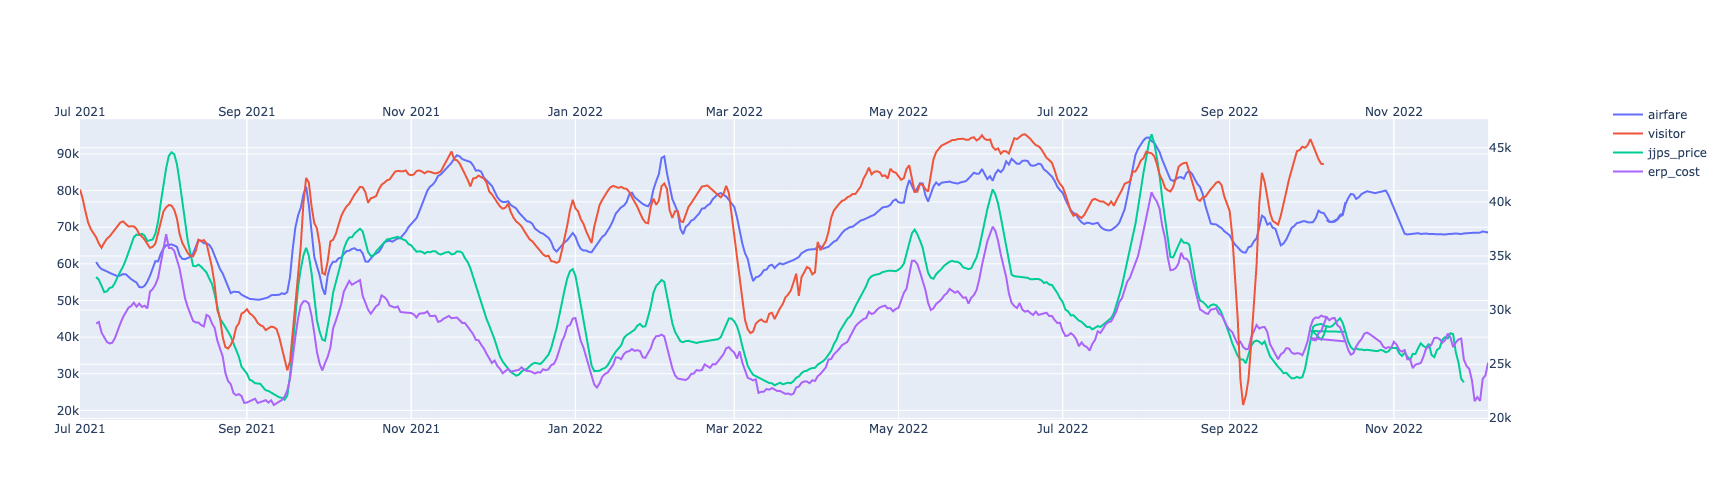

In [559]:
fig=make_subplots(
        specs=[[{"secondary_y": True}]])   

fig.update_layout(xaxis2= {'anchor': 'y', 'overlaying': 'x', 'side': 'top'},
                  yaxis_domain=[0, 0.94]);

fig.add_trace(
    go.Scatter(x=af_vst_prc_cst['date'], y=af_vst_prc_cst['fare_avg_7ma'], name="airfare"),
    secondary_y=False
)

fig.add_trace(
    go.Scatter(x=af_vst_prc_cst['date'], y=af_vst_prc_cst['visitor_7ma'], name="visitor"),
    secondary_y=True
)

fig.add_trace(
    go.Scatter(x=af_vst_prc_cst['date'], y=af_vst_prc_cst['jjps_hour_price_7ma']*20, name="jjps_price"),
    secondary_y=False
)

fig.add_trace(
    go.Scatter(x=af_vst_prc_cst['date'], y=af_vst_prc_cst['erp_hour_cost_7ma']*20, name="erp_cost"),
    secondary_y=False
)


fig.data[1].update(xaxis='x2')
fig.update_layout(width=1500, height=500)


fig.show()

# fig.show()
#plot(fig, filename='airfare_visitor.html')

### 제주패스 렌트카 가격 리드타임에 트렌드 시각화

In [563]:
#2021년 리드타임별 판매가 추이
jjps01_21=jjps01[jjps01['accept_year']==2021]
jjps01_21_lt=pd.DataFrame(jjps01_21.groupby('lead_time')['jjps_hour_price'].mean().round(0)).reset_index()
jjps01_21_lt

,lead_time,jjps_hour_price
0,0,1971.0
1,1,2059.0
2,2,2203.0
3,3,2315.0
4,4,2379.0
...,...,...
56,56,3238.0
57,57,3609.0
58,58,3222.0
59,59,3787.0


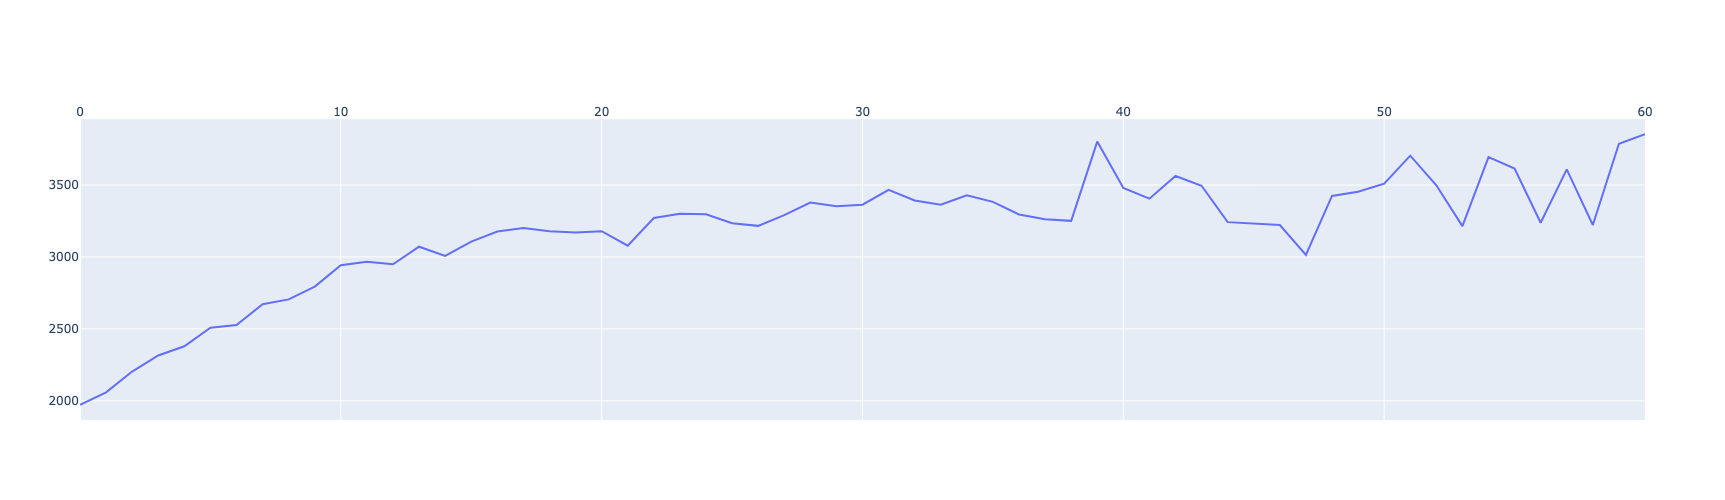

'2021_hourly_pay_lead_time.html'

In [564]:
fig=make_subplots(
        specs=[[{"secondary_y": True}]])   

fig.update_layout(xaxis2= {'anchor': 'y', 'overlaying': 'x', 'side': 'top'},
                  yaxis_domain=[0, 0.94]);

fig.add_trace(
    go.Scatter(x=jjps01_21_lt['lead_time'], y=jjps01_21_lt['jjps_hour_price'], name="pay/hour on leat_time"),
    secondary_y=False
)

# fig.add_trace(
#     go.Scatter(x=cost_hour['date'], y=cost_hour['visitor_7ma'], name="visitor"),
#     secondary_y=True
# )

fig.data[0].update(xaxis='x2')
fig.update_layout(width=1000, height=500)


fig.show()

# fig.show()
plot(fig, filename='2021_hourly_pay_lead_time.html')

In [565]:
#2022년 리드타임별 판매가 추이
jjps01_22=jjps01[jjps01['accept_year']==2022]
jjps01_22_lt=pd.DataFrame(jjps01_22.groupby('lead_time')['jjps_hour_price'].mean().round(0)).reset_index()
jjps01_22_lt

,lead_time,jjps_hour_price
0,0,1973.0
1,1,2050.0
2,2,2157.0
3,3,2206.0
4,4,2253.0
...,...,...
56,56,3340.0
57,57,3315.0
58,58,3350.0
59,59,3215.0


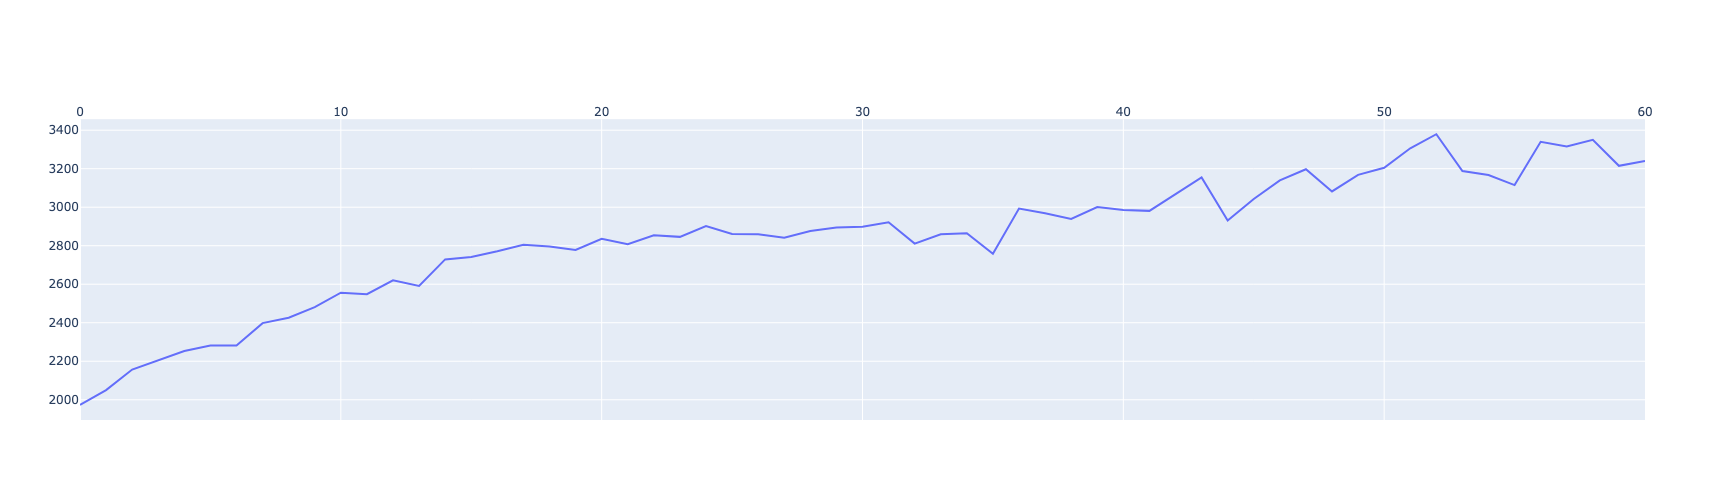

'2022_hourly_pay_lead_time.html'

In [566]:
fig=make_subplots(
        specs=[[{"secondary_y": True}]])   

fig.update_layout(xaxis2= {'anchor': 'y', 'overlaying': 'x', 'side': 'top'},
                  yaxis_domain=[0, 0.94]);

fig.add_trace(
    go.Scatter(x=jjps01_22_lt['lead_time'], y=jjps01_22_lt['jjps_hour_price'], name="pay/hour on leat_time"),
    secondary_y=False
)

# fig.add_trace(
#     go.Scatter(x=cost_hour['date'], y=cost_hour['visitor_7ma'], name="visitor"),
#     secondary_y=True
# )

fig.data[0].update(xaxis='x2')
fig.update_layout(width=1000, height=500)


fig.show()

# fig.show()
plot(fig, filename='2022_hourly_pay_lead_time.html')

### 2021년 수요곡선 - x축 제주패스 수수료%, y축 판매량

In [572]:
# erp_type01과 jjps01 두개 테이블 결합

In [571]:
# erp_type01의 필요한 컬럼 : jejupass_reserve_no, company_name, model_final_final, date, erp_hour_cost 

In [593]:
set(list(erp_type01['model_name_final']))

{'넥스트스파크',
 '더 뉴 스파크',
 '더뉴 스파크',
 '더뉴모닝',
 '더뉴스파크',
 '모닝',
 '모닝 어반',
 '모닝 어반 2022',
 '모닝 휘발유 2017',
 '모닝 휘발유 2017 ',
 '모닝 휘발유 2020',
 '모닝어반',
 '모닝어반2022  만21세',
 '스파크',
 '올뉴 모닝',
 '올뉴모닝',
 '올뉴모닝  긴출',
 '올뉴모닝 휘발유 2016',
 '올뉴모닝럭셔리',
 '캐스퍼',
 '캐스퍼 인스퍼레이션'}

In [576]:
erp_type01_cost=erp_type01[['jejupass_reserve_no', 'company_name', 'model_name_final', 'date', 'erp_hour_cost']]
erp_type01_cost

,jejupass_reserve_no,company_name,model_name_final,date,erp_hour_cost
428,None,루프제주렌트카,모닝,2022-10-06,1250.0
429,None,루프제주렌트카,모닝,2022-10-06,1250.0
441,None,루프제주렌트카,모닝,2022-09-28,1333.0
442,None,루프제주렌트카,모닝,2022-09-28,1250.0
443,None,루프제주렌트카,모닝,2022-09-28,1250.0
...,...,...,...,...,...
892512,2203019202553,퍼시픽렌터카(제주),캐스퍼 인스퍼레이션,2022-03-14,2634.0
892513,ticket_621ac495cfd05,퍼시픽렌터카(제주),캐스퍼 인스퍼레이션,2022-03-05,2409.0
892515,2202235201179,퍼시픽렌터카(제주),캐스퍼 인스퍼레이션,2022-03-02,2267.0
892516,2202227201428,퍼시픽렌터카(제주),캐스퍼 인스퍼레이션,2022-02-26,3672.0


In [583]:
# 시간순 정렬
erp_type01_cost=erp_type01_cost.sort_values(by='date')
erp_type01_cost

In [612]:
erp_type01_cost

,jejupass_reserve_no,company_name,model_name_final,date,erp_hour_cost
178206,None,메트로렌트카,모닝,2021-01-01,756.0
382590,210101-14419042@3676,KD렌트카,올뉴모닝 긴출,2021-01-01,540.0
576180,None,녹원렌터카,모닝,2021-01-01,1915.0
449448,2101017117598,신동아렌터카,올뉴모닝,2021-01-01,473.0
633663,None,인터파크렌트카,올뉴모닝럭셔리,2021-01-01,0.0
...,...,...,...,...,...
380761,20220827009958,아산렌트카,더뉴스파크,2023-02-05,1886.0
837701,20220902003746,아산렌트카,더뉴스파크,2023-04-11,1902.0
248855,ticket_632cf0e965a27,아산렌트카,더뉴스파크,2023-04-29,3512.0
709050,None,제주OK렌터카,더뉴모닝,2023-05-04,0.0


In [629]:
erp_type01_cost_count=erp_type01_cost.groupby('erp_hour_cost').size().to_frame().reset_index()
erp_type01_cost_count.columns=['erp_hour_cost','count']

In [630]:
erp_type01_cost_count

,erp_hour_cost,count
0,0.0,439
1,2.0,1
2,21.0,1
3,42.0,1
4,125.0,3
...,...,...
4282,13271.0,1
4283,15214.0,1
4284,16000.0,1
4285,20833.0,1


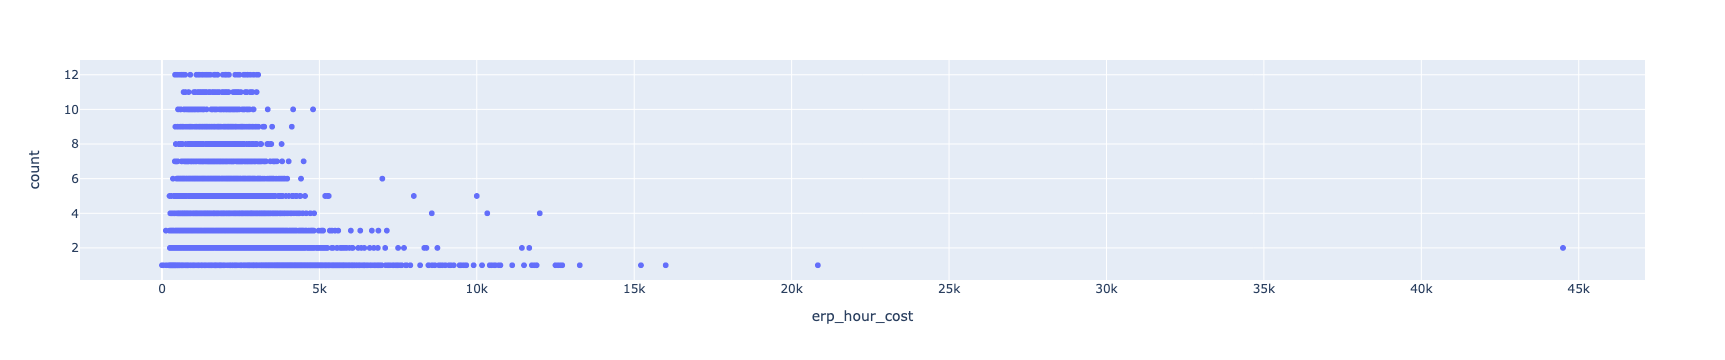

In [661]:
q3 = erp_type01_cost_count.quantile(0.75) 
q1 = erp_type01_cost_count.quantile(0.25)

iqr = q3 - q1

def is_outlier(df):
    count = df['count']
    if count > q3['count'] + 1.5 * iqr['count'] or count < q1['count'] - 1.5 * iqr['count']:
        return True
    else:
        return False

erp_type01_cost_count['outlier'] = erp_type01_cost_count.apply(is_outlier, axis = 1)

erp_type01_cost_count_no=erp_type01_cost_count.loc[erp_type01_cost_count['outlier'] == False]

fig = px.scatter(erp_type01_cost_count_no, x="erp_hour_cost", y="count")
fig.show()

In [573]:
# jjps01의 필요한 컬럼 : reserve_no, car_type, date, jjps_hour_price, lead_time, quarter, accept_year

In [578]:
jjps01_price=jjps01[['reserve_no', 'car_type', 'date', 'jjps_hour_price', 'lead_time', 'quarter', 'accept_year']]

,reserve_no,car_type,date,jjps_hour_price,lead_time,quarter,accept_year
487759,2101015116899,01,2021-01-01,440.0,0,1,2021
635794,2101012118000,01,2021-01-01,638.0,0,1,2021
123244,2101011117644,01,2021-01-01,370.0,0,1,2021
293204,2101014117664,01,2021-01-01,793.0,0,1,2021
796171,2101017117598,01,2021-01-01,640.0,0,1,2021
...,...,...,...,...,...,...,...
960717,20221001009874,01,2022-12-01,3867.0,60,4,2022
527601,20221003002968,01,2022-12-02,2849.0,59,4,2022
527602,20221003002879,01,2022-12-02,2849.0,59,4,2022
681984,2210053209373,01,2022-12-03,1610.0,58,4,2022


In [599]:
jjps01_price_count=jjps01_price.groupby('jjps_hour_price').size().to_frame().reset_index()

In [600]:
jjps01_price_count.columns=['jjps_hour_price','count']

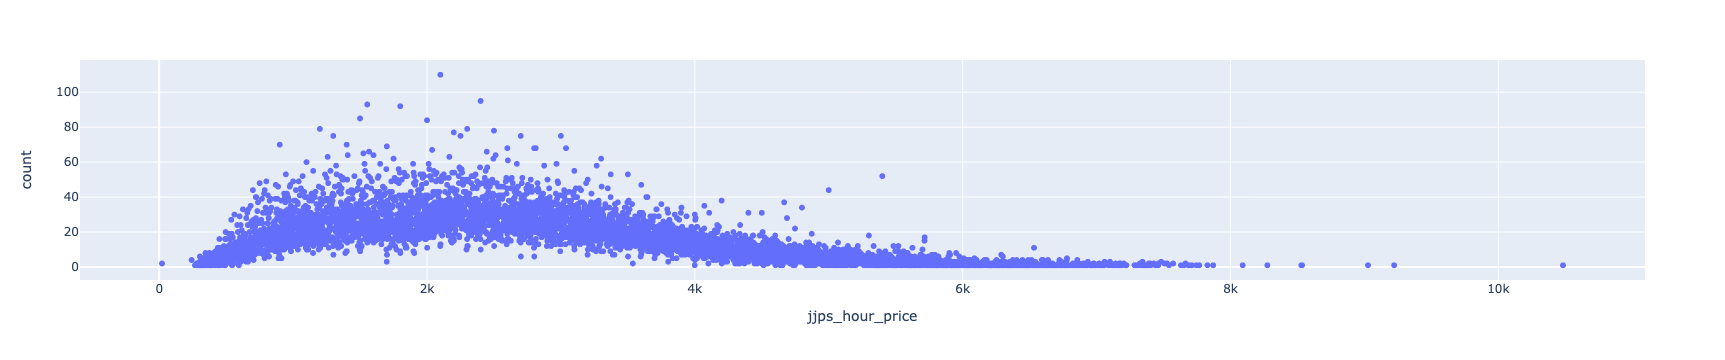

In [604]:
fig = px.scatter(jjps01_price_count, x="jjps_hour_price", y="count")
fig.show()

In [ ]:
# 통계 관점 기술적 아웃라이어 제거

In [635]:
q3 = jjps01_price_count.quantile(0.75) 
q1 = jjps01_price_count.quantile(0.25)

iqr = q3 - q1

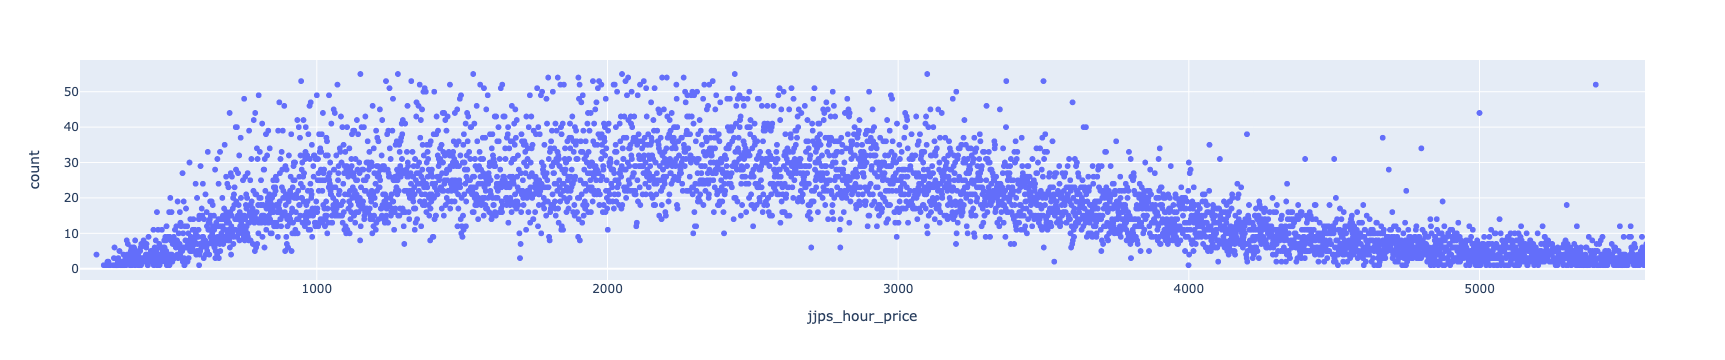

In [636]:
def is_outlier(df):
    count = df['count']
    if count > q3['count'] + 1.5 * iqr['count'] or count < q1['count'] - 1.5 * iqr['count']:
        return True
    else:
        return False

jjps01_price_count['outlier'] = jjps01_price_count.apply(is_outlier, axis = 1)

jjps01_price_count_no=jjps01_price_count.loc[jjps01_price_count['outlier'] == False]

fig = px.scatter(jjps01_price_count_no, x="jjps_hour_price", y="count")
fig.show()

In [585]:
jjps01_price.columns=['jejupass_reserve_no','car_type','date','jjps_hour_price','lead_time','quarter','accept_year']

In [638]:
jjps_erp01=jjps01_price.merge(erp_type01_cost, how='inner', on='jejupass_reserve_no')

In [639]:
jjps_erp01

,jejupass_reserve_no,car_type,date_x,jjps_hour_price,lead_time,quarter,accept_year,company_name,model_name_final,date_y,erp_hour_cost
0,2101012118000,01,2021-01-01,638.0,0,1,2021,신동아렌터카,올뉴모닝,2021-01-01,472.0
1,2101014117664,01,2021-01-01,793.0,0,1,2021,신동아렌터카,올뉴모닝,2021-01-01,586.0
2,2101017117598,01,2021-01-01,640.0,0,1,2021,신동아렌터카,올뉴모닝,2021-01-01,473.0
3,2101013117109,01,2021-01-02,698.0,0,1,2021,신동아렌터카,올뉴모닝,2021-01-02,516.0
4,2101035117004,01,2021-01-03,613.0,0,1,2021,신동아렌터카,모닝 어반,2021-01-03,454.0
...,...,...,...,...,...,...,...,...,...,...,...
4913,20221003002325,01,2022-11-11,3363.0,38,4,2022,신동아렌터카,캐스퍼,2022-11-11,2586.0
4914,20220930008328,01,2022-11-15,2258.0,45,4,2022,제주OK렌터카,더뉴모닝,2022-11-15,1766.0
4915,20221005005746,01,2022-11-17,2234.0,43,4,2022,신동아렌터카,모닝 어반,2022-11-17,1719.0
4916,20221004003889,01,2022-11-18,2187.0,45,4,2022,제주타요렌터카,더뉴스파크,2022-11-18,1823.0


In [645]:
jjps_erp01['margin']=((jjps_erp01['jjps_hour_price']-jjps_erp01['erp_hour_cost'])/jjps_erp01['jjps_hour_price']).round(2)

In [646]:
jjps_erp01

,jejupass_reserve_no,car_type,date_x,jjps_hour_price,lead_time,quarter,accept_year,company_name,model_name_final,date_y,erp_hour_cost,margin
0,2101012118000,01,2021-01-01,638.0,0,1,2021,신동아렌터카,올뉴모닝,2021-01-01,472.0,0.26
1,2101014117664,01,2021-01-01,793.0,0,1,2021,신동아렌터카,올뉴모닝,2021-01-01,586.0,0.26
2,2101017117598,01,2021-01-01,640.0,0,1,2021,신동아렌터카,올뉴모닝,2021-01-01,473.0,0.26
3,2101013117109,01,2021-01-02,698.0,0,1,2021,신동아렌터카,올뉴모닝,2021-01-02,516.0,0.26
4,2101035117004,01,2021-01-03,613.0,0,1,2021,신동아렌터카,모닝 어반,2021-01-03,454.0,0.26
...,...,...,...,...,...,...,...,...,...,...,...,...
4913,20221003002325,01,2022-11-11,3363.0,38,4,2022,신동아렌터카,캐스퍼,2022-11-11,2586.0,0.23
4914,20220930008328,01,2022-11-15,2258.0,45,4,2022,제주OK렌터카,더뉴모닝,2022-11-15,1766.0,0.22
4915,20221005005746,01,2022-11-17,2234.0,43,4,2022,신동아렌터카,모닝 어반,2022-11-17,1719.0,0.23
4916,20221004003889,01,2022-11-18,2187.0,45,4,2022,제주타요렌터카,더뉴스파크,2022-11-18,1823.0,0.17


In [648]:
jjps_erp01_count=jjps_erp01.groupby('margin').size().to_frame().reset_index()
jjps_erp01_count.columns=['margin','count']

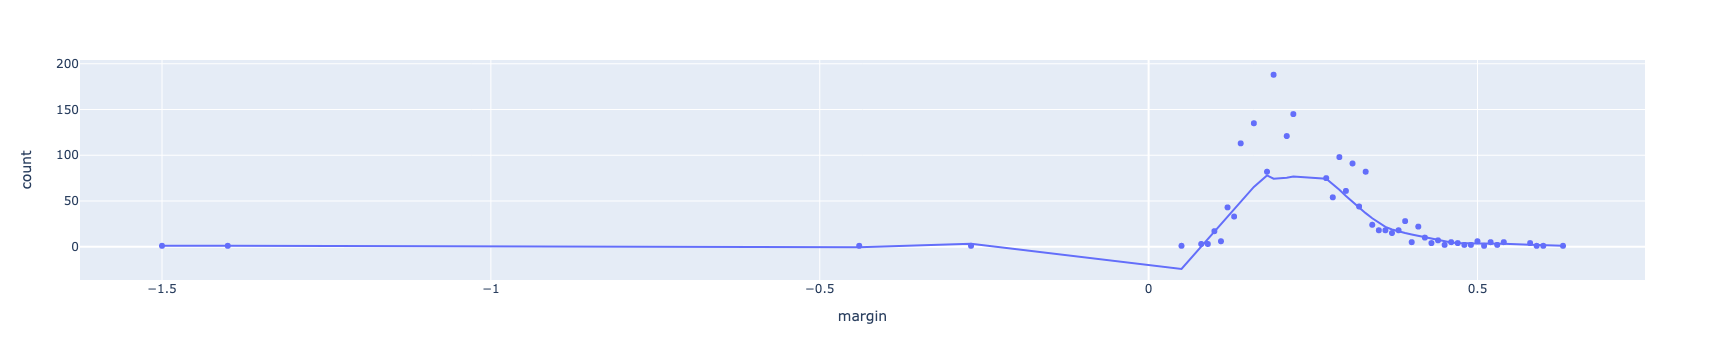

In [662]:
q3 = jjps_erp01_count.quantile(0.75) 
q1 = jjps_erp01_count.quantile(0.25)

iqr = q3 - q1

def is_outlier(df):
    count = df['count']
    if count > q3['count'] + 1.5 * iqr['count'] or count < q1['count'] - 1.5 * iqr['count']:
        return True
    else:
        return False

jjps_erp01_count['outlier'] = jjps_erp01_count.apply(is_outlier, axis = 1)

jjps_erp01_count_no=jjps_erp01_count.loc[jjps_erp01_count['outlier'] == False]

fig = px.scatter(jjps_erp01_count_no, x="margin", y="count", trendline='lowess', trendline_options=dict(frac=0.3))
fig.show()

In [676]:
jjps_erp01_count_filter = jjps_erp01_count[(jjps_erp01_count['margin']>=0.19) & (jjps_erp01_count['margin']<=0.35) & (jjps_erp01_count['outlier']==False) ]
jjps_erp01_count_filter

,margin,count,outlier
16,0.19,188,False
18,0.21,121,False
19,0.22,145,False
24,0.27,75,False
25,0.28,54,False
26,0.29,98,False
27,0.30,61,False
28,0.31,91,False
29,0.32,44,False
30,0.33,82,False


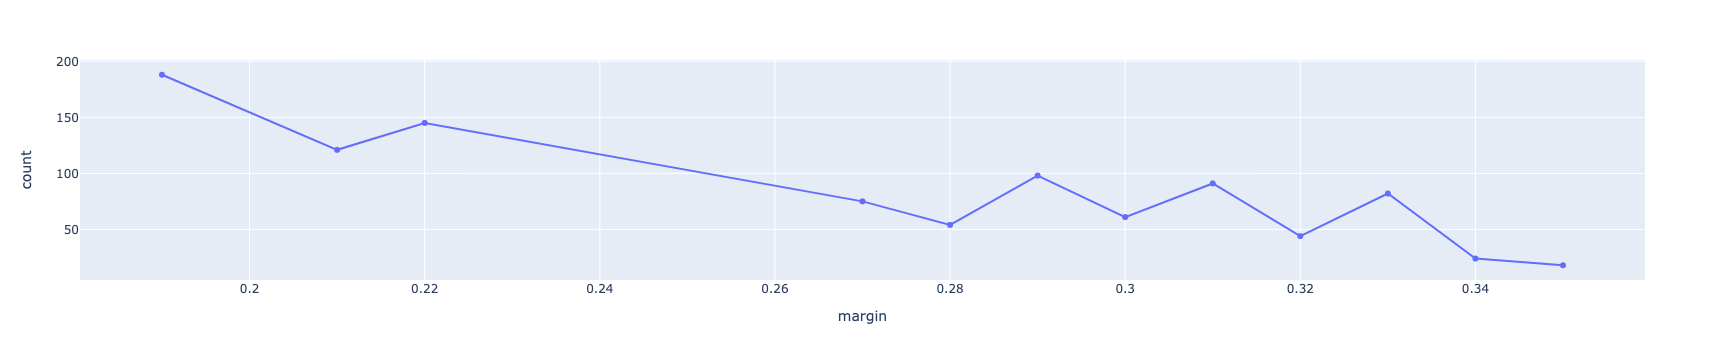

In [677]:
fig = px.scatter(jjps_erp01_count_filter, x="margin", y="count", trendline='lowess', trendline_options=dict(frac=0.15))
fig.show()

In [683]:
x=np.array(jjps_erp01_count_filter['margin'].values)

In [684]:
y=np.array(jjps_erp01_count_filter['count'].values)

In [685]:
def func(X,a):
    return (1/X)**a

In [686]:
popt, pcov = curve_fit(func, x, y, method="lm")
print(popt)

[3.20106867]


In [688]:
from matplotlib import pyplot as plt

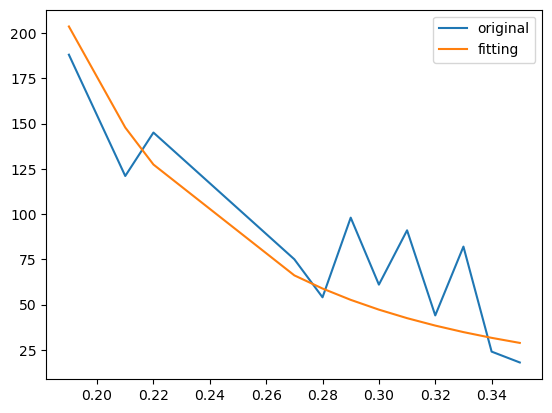

In [689]:
plt.plot(x,y, label='original')
plt.plot(x, func(x, *popt), label='fitting')
plt.legend()

### 시각화

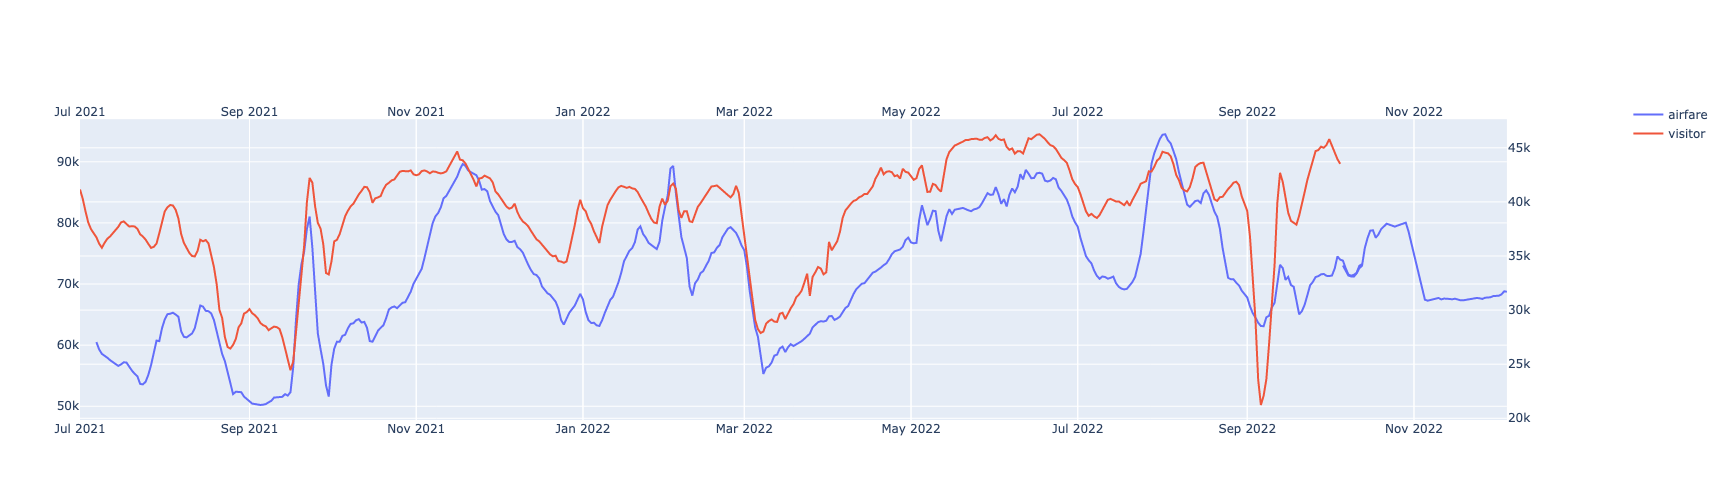

'airfare_visitor.html'

In [107]:
fig=make_subplots(
        specs=[[{"secondary_y": True}]])   

fig.update_layout(xaxis2= {'anchor': 'y', 'overlaying': 'x', 'side': 'top'},
                  yaxis_domain=[0, 0.94]);

fig.add_trace(
    go.Scatter(x=airfare_visitor['date'], y=airfare_visitor['fare_avg_7ma'], name="airfare"),
    secondary_y=False
)

fig.add_trace(
    go.Scatter(x=airfare_visitor['date'], y=airfare_visitor['visitor_7ma'], name="visitor"),
    secondary_y=True
)

fig.data[1].update(xaxis='x2')
fig.update_layout(width=1500, height=500)


fig.show()

# fig.show()
plot(fig, filename='airfare_visitor.html')